In [1]:
%pylab inline
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import scipy.stats
from MTD import *
import brewer2mpl
from scipy.stats.mstats import zscore as zscore

Populating the interactive namespace from numpy and matplotlib


In [3]:
#read data
%run dataframe_ts.py
#TS_df = pd.read_csv('../Data/TS_FIRReg_df.csv')
TS_df.head()

,Time,Subject,Condition,Dataset,Run,FFA,PPA,VC
0,1,512,FH,FIR,1,-0.260637,0.068294,-0.214295
1,2,512,FH,FIR,1,-0.198729,0.217280,-0.404957
2,3,512,FH,FIR,1,-0.274314,-0.397993,-1.028810
3,4,512,FH,FIR,1,-0.327794,-0.277384,-0.317825
4,5,512,FH,FIR,1,0.123660,-0.433729,-0.268533


In [4]:
Subjects = [503,505,508,509,510,512,513,516,517,518,519,523,527,528,529,530,531,532,534,536,537,539,540,542,546,547,549,550]
Conditions = ['FH', 'Fp', 'HF', 'Hp']
#MotorMapping = [1, 2]
corr_df = pd.DataFrame(columns=['Subj', 'Condition', 'Run','Window', 'MTD-FFA-VC', 'MTD-PPA-VC', 'corr-FFA-VC', 'corr-PPA-VC'], dtype=float)
#'Run', 'FFA-M','FFA-NM', 'PPA-M', 'PPA-NM',
Runs = [1, 2, 3, 4]
#motor mapping 1, RH-Face LH-Scene
#motor mapping 2, RH-Scene, LH-Face

# block start times and TRs:
# 1.50 42.00 82.50 121.50
# 0, 27, 54, 80
TR_index = np.arange(0,98)
TR_index[TR_index!=0] == False 
TR_index[0:12] = True
TR_index[24:39] = True
TR_index[51:66] = True
TR_index[80:92] = True

i=1
for s, sub in enumerate(Subjects):
    for c, cond in enumerate(Conditions):
        for run in Runs:
            PPA_ts = np.array(TS_df[(TS_df['Subject'] == str(sub)) & (TS_df['Condition'] == cond) & (TS_df['Run'] == run)]['PPA'])
            FFA_ts = np.array(TS_df[(TS_df['Subject'] == str(sub)) & (TS_df['Condition'] == cond) & (TS_df['Run'] == run)]['FFA'])
            VC_ts = np.array(TS_df[(TS_df['Subject'] == str(sub)) & (TS_df['Condition'] == cond) & (TS_df['Run'] == run)]['VC'])
            
            #cal coupling
            #cfv = np.corrcoef(np.array([FFA_ts, VC_ts]))[0,1]
            #cfp = np.corrcoef(np.array([PPA_ts, VC_ts]))[0,1]
            
            for w in np.arange(1,25):
                corr_df.loc[i, 'Condition'] = cond
                corr_df.loc[i, 'Subj'] = sub
                corr_df.loc[i, 'Run'] = run
                corr_df.loc[i, 'Window'] = w
                corr_df.loc[i,'MTD-FFA-VC'] = np.nanmean(coupling(np.array([FFA_ts, VC_ts]).T, w)[1][:,0,1][TR_index])
                corr_df.loc[i,'MTD-PPA-VC'] = np.nanmean(coupling(np.array([PPA_ts, VC_ts]).T, w)[1][:,0,1][TR_index])
                
                sT = pd.rolling_mean(np.array([FFA_ts, VC_ts]).T,w, center = True)
                sT[np.isnan(sT)] = 0
                corr_df.loc[i,'corr-FFA-VC'] = np.corrcoef(sT.T)[0,1]
                
                sT = pd.rolling_mean(np.array([PPA_ts, VC_ts]).T,w, center = True)
                sT[np.isnan(sT)] = 0
                corr_df.loc[i,'corr-PPA-VC'] = np.corrcoef(sT.T)[0,1]
                
                i = i+1

MTD.py:46: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  sma = pd.rolling_mean(temp,window, center = True)
/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:44: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


In [18]:
stat_df = corr_df.groupby(['Subj','Condition','Window']).mean().reset_index()
#stat_df.head()

mean_df = stat_df.groupby(['Condition','Window']).mean().reset_index()
sem_df = stat_df.groupby(['Condition','Window']).sem().reset_index()
mean_df.head()
#sem_df.head()

,Condition,Window,Subj,Run,MTD-FFA-VC,MTD-PPA-VC,corr-FFA-VC,corr-PPA-VC
0,FH,1.0,526.785714,2.5,0.283157,0.055588,0.251998,0.054139
1,FH,2.0,526.785714,2.5,0.297224,0.089876,0.267131,0.052200
2,FH,3.0,526.785714,2.5,0.285835,0.094431,0.274871,0.049880
3,FH,4.0,526.785714,2.5,0.239140,0.097317,0.278674,0.055266
4,FH,5.0,526.785714,2.5,0.237316,0.095761,0.277349,0.064639


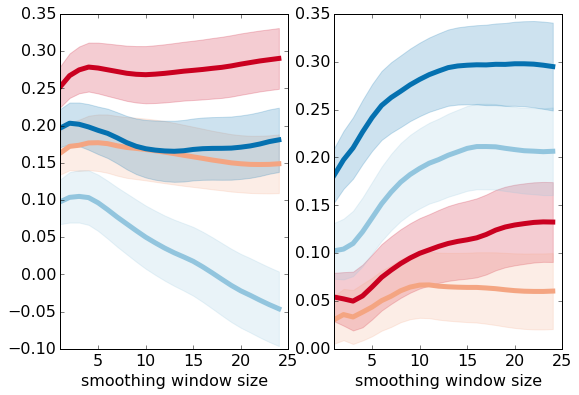

In [33]:
plt.rc('xtick', labelsize=16)  
plt.rc('ytick', labelsize=16) 
ROIpairs = ['corr-FFA-VC', 'corr-PPA-VC']
Conditions =['FH', 'Fp', 'Hp', 'HF']
Labels = ['Face with scene distractor', 'Passively viewing faces ', 'Passively viewing scenes', 'Scene with face distractor']
x = np.arange(1,25)
#get colormap
cmap = brewer2mpl.get_map('RdBu','diverging', 4)
plt.figure(1)
plt.figure(figsize=(9,6))
#plt.suptitle('FIR regression', fontsize=14, fontweight='bold')
for r, roi in enumerate(ROIpairs):
    ax=plt.subplot(1, 2, r+1)
    
    for i, c in enumerate(Conditions):
        y = np.array(mean_df[(mean_df['Condition'] == c)][roi])
        error = np.array(sem_df[(mean_df['Condition'] == c)][roi])
        plt.plot(x, y, color = cmap.hex_colors[i], linewidth=5  )
        #ax.set_title(roi)
        plt.fill_between(x, y-0.8*error, y+0.8*error, alpha=0.2, edgecolor=cmap.hex_colors[i], 
                     facecolor=cmap.hex_colors[i], label=c)

        #plt.ylim(-0.1,0.3)
        plt.xlim(1, 25)
        plt.xlabel('smoothing window size', fontsize=16)
#plt.legend(Labels, fontsize=14, loc='outside', bbox_to_anchor=(1, 1))
#plt.show()
plt.savefig('/home/despoB/kaihwang/bin/TDSigEI/FIRreg_MTD_v_corr_lags1-25.pdf',bbox_inches='tight')

In [39]:
stat_df.groupby(['Condition','Subj']).mean().reset_index().to_csv('/home/despoB/kaihwang/bin/TDSigEI/Data/conn.csv')

In [2]:
%run dataframe_MTD_b.py

In [4]:
TS_df.head()

,W,Subject,beta
0,5,512,-0.022484
1,7,512,-0.021283
2,9,512,-0.039176
3,11,512,-0.037256
4,13,512,-0.051605


In [8]:
mean_df = TS_df.groupby(['W']).mean()
sd_Df =TS_df.groupby(['W']).sem()

In [13]:
mean_df


,beta
W,
5,-0.009368
7,-0.015038
9,-0.020496
11,-0.029753
13,-0.036591
15,-0.044333
17,-0.036625
19,-0.034221


In [12]:
sd_Df

,Subject,beta
W,,
5,NaN,0.004005
7,NaN,0.002951
9,NaN,0.005390
11,NaN,0.006498
13,NaN,0.006936
15,NaN,0.007259
17,NaN,0.008514
19,NaN,0.010732
